In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "1,2"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring


inputs is a matrix where each row represents a simulation and each column is a feature:
1) shape
2) size -----? is scalable to other properties(radius, length)
3) radius
4) radius polydispersity rWidth
5) length
6) lengrh polydispersity lWidth
7) theta rotation
8) theta polydispersity
9) theta distr
10) phi rotation
11) phi polydipersity
12) phi  distr

In [6]:
def shape_condition(true_shape):
    a,b=1,1
    if true_shape=='hardsphere':
        while a+b>=1:
            b=np.random.normal(0.8, 0.2)
            if b<1:
                a = np.random.uniform(0, (1-b)/2)
        c = 1-a-b    
        return torch.tensor([a,b,c])
    else:
        # if sphere or cylinder probs are calculated similarly
        while a+b>=1:
            a,b=np.random.normal(0.55, 0.1),np.random.normal(0.05, 0.05)
        c = 1-a-b
        if true_shape=='sphere':
            return torch.tensor([a,b,c])  
        else:
            return torch.tensor([c,b,a])    
    

In [7]:
'''Global configuration for the experiments'''

######################
#  General settings  #
######################

# Filename to save the model under
filename_out    = 'output/cond_inn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-4
#Batch size
batch_size      = 256
# Total number of epochs to train for
n_epochs        = 50

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_pad_x_class = 397
ndim_x_features     = 7
ndim_pad_x_features = 593

ndim_y     = 512
ndim_z     = 2
ndim_pad_zy = 486 

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert (ndim_x_class + ndim_x_features + ndim_pad_x_class+ ndim_pad_x_features 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = False
train_max_likelihood = False

lambd_fit_forw         = 10.
lambd_mmd_forw         = 50.
lambd_reconstruct      = 1.
lambd_mmd_back_class   = 50.
lambd_mmd_back_feature = 50.
lambd_max_likelihood   = 1.

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 5e-2 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 3.0
#
hidden_layer_sizes = 32
#
use_permutation = True
#
verbose_construction = False

In [8]:
def read_data(path):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
    labels = torch.zeros(len(files), ndim_y, dtype = torch.float32)
    inputs = torch.zeros(len(files), ndim_x_class+ndim_x_features, dtype = torch.float32)
    conditions = torch.zeros(len(files), ndim_x_class, dtype = torch.float32)
    input_keys = ['shape', 'radius', 'radius_pd','length', 'length_pd',  'volfraction']
    for i,f in enumerate(files):
        with  h5py.File(os.path.join(path,f),'r') as file:
            print(file, end = '\r')
            labels[i,:] = torch.from_numpy(file['entry/I'][()].flatten())#I_noisy
            for i_k, key in enumerate(input_keys):
                try:
                    if key == 'shape':
                        shape = file['properties'][key][()].decode("utf-8")
                        if shape == 'sphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([1,0,0]) 
                            #conditions[i, i+k]
                        elif shape == 'hardsphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([0,1,0])
                        else:
                            inputs[i, i_k:i_k+3] = torch.tensor([0,0,1])
                        conditions[i, i_k:i_k+3] = shape_condition(shape)
                    elif key =='radius':
                        if shape == 'sphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([file['properties'][key][()],0,0]) 
                        elif shape == 'hardsphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,file['properties'][key][()],0])
                        else:
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,0,file['properties'][key][()]])
                    else:
                        inputs[i, i_k+4] = file['properties'][key][()]
                except KeyError:
                    # spheres don't have all of the properties a cylinder does
                    pass
    return torch.cat((inputs,conditions),1), labels
            

In [9]:
inputs,labels = read_data('/home/slaskina/simulations')

In [10]:

# Creating data indices for training and validation splits:
dataset_size = len(labels)
indices = list(range(dataset_size))
test_size = 0.1
val_size = 0.2
test_split = int(np.floor(test_size * dataset_size))
val_split = int(np.floor(val_size * dataset_size))
np.random.seed(1234)
np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:dataset_size-test_split-val_split], indices[dataset_size-test_split-val_split:dataset_size-test_split], indices[dataset_size-test_split:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)


In [11]:
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(inputs, labels), batch_size=batch_size, drop_last=True, sampler = val_sampler)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(inputs, labels), batch_size=batch_size, drop_last=True, sampler = train_sampler)

### from here are the model and train modeules are defined to avoid restarting 

In [12]:
def subnet2(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))


def subnet1(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes*2), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes*2,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))

input1 = Ff.InputNode(ndim_x_class + ndim_pad_x_class, name='input_class')
input2 = Ff.InputNode(ndim_x_features + ndim_pad_x_features, name='input_features')

shape_condition = Ff.ConditionNode(ndim_x_class, name='input_class')
nodes = [input1]
nodes.append(shape_condition)
nodes.append(Ff.Node(nodes[-2].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet2, 'clamp':exponent_clamping},conditions = nodes[-1], name = 'coupling_conditioned'))
if use_permutation:
    nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':100}, name='permute_middle'))

for i in range(N_blocks):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet1, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))
    if use_permutation:
        nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='permute_{}'.format(i)))

nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet2, 'clamp':exponent_clamping},conditions = nodes[-1-(N_blocks+1)*2], name = 'coupling_conditioned'))
if use_permutation:
    nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':100}, name='permute_middle'))

nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet2, 'clamp':exponent_clamping},conditions = nodes[-1-(N_blocks+2)*2], name = 'coupling_conditioned'))
if use_permutation:
    nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':100}, name='permute_middle'))

nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet2, 'clamp':exponent_clamping},conditions = nodes[-1-(N_blocks+3)*2], name = 'coupling_conditioned'))
if use_permutation:
    nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':100}, name='permute_middle'))

nodes.append(input2)
nodes.append( Ff.Node([nodes[-2].out0, nodes[-1].out0], Fm.Concat, {}, name='Concat'))
for i in range(N_blocks):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet2, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))
    if use_permutation:
        nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='permute_{}'.format(i)))

nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model = Ff.GraphINN(nodes, verbose=verbose_construction)
      
model.to(device)

params_trainable = list(filter(lambda p: p.requires_grad, model.parameters()))
for p in params_trainable:
    p.data = init_scale * torch.randn(p.data.shape).to(device)

gamma = (final_decay)**(1./n_epochs)
optim = torch.optim.Adam(params_trainable, lr=lr_init, betas=adam_betas, eps=1e-6, weight_decay=l2_weight_reg)
weight_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=gamma)

def optim_step():
    #for p in params_trainable:
        #print(torch.mean(torch.abs(p.grad.data)).item())
    optim.step()
    optim.zero_grad()

def scheduler_step():
    #weight_scheduler.step()
    pass

def save(name):
    torch.save({'opt':optim.state_dict(),
                'net':model.state_dict()}, name)

def load(name):
    state_dicts = torch.load(name)
    model.load_state_dict(state_dicts['net'])
    try:
        optim.load_state_dict(state_dicts['opt'])
    except ValueError:
        print('Cannot load optimizer for some reason or other')


In [13]:

def noise_batch(ndim):
    return torch.randn(batch_size, ndim).to(device)

def loss_max_likelihood(out, y):
    jac = model.jacobian(run_forward=False)

    neg_log_likeli = ( 0.5 / y_uncertainty_sigma**2 * torch.sum((out[:, -ndim_y:]       - y[:, -ndim_y:])**2, 1)
                     + 0.5 / zeros_noise_scale**2   * torch.sum((out[:, ndim_z:-ndim_y] - y[:, ndim_z:-ndim_y])**2, 1)
                     + 0.5 * torch.sum(out[:, :ndim_z]**2, 1)
                     - jac)

    return lambd_max_likelihood * torch.mean(neg_log_likeli)

def loss_forward_mmd(out, y):
    # Shorten output, and remove gradients wrt y, for latent loss
    # [z,y] only
    output_block_grad = torch.cat((out[:, :ndim_z],
                                   out[:, -ndim_y:].data), dim=1) 
    y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

    l_forw_fit = lambd_fit_forw * losses.l2_fit(out[:, ndim_z:], y[:, ndim_z:])
    l_forw_mmd = lambd_mmd_forw  * torch.mean(losses.forward_mmd(output_block_grad, y_short))

    return l_forw_fit, l_forw_mmd

def loss_backward_mmd(x_class, x_features, y, x_cond):
    [x_samples_class, x_samples_features], x_samples_jac = model(y, rev=True, jac = False,c= x_cond) 
    MMD_class = losses.backward_mmd(x_class, x_samples_class) 
    MMD_features = losses.backward_mmd(x_features, x_samples_features)
    if mmd_back_weighted:
        MMD_class *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
        MMD_features *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
    return lambd_mmd_back_class * torch.mean(MMD_class)+lambd_mmd_back_feature * torch.mean(MMD_features)


def loss_reconstruction(out_y, x, x_cond):
    cat_inputs = [out_y[:, :ndim_z] + add_z_noise * noise_batch(ndim_z)] # list with 1 tensor
    
    if ndim_pad_zy:
        cat_inputs.append(out_y[:, ndim_z:-ndim_y] + add_pad_noise * noise_batch(ndim_pad_zy)) # list with 2 tensor
    cat_inputs.append(out_y[:, -ndim_y:] + add_y_noise * noise_batch(ndim_y)) # list with 3 tensors
    x_reconstructed_class, x_reconstructed_features, x_reconstructed_jac = model(torch.cat(cat_inputs, 1), rev=True,c= x_cond) # concatenate list elements along axis 1
    return lambd_reconstruct * losses.l2_fit(x_reconstructed, x) # needs fix

def train_epoch(i_epoch, test=False):
    if not test:
        model.train()
        loader = train_loader

    if test:
        model.eval()
        loader = test_loader
        nograd = torch.no_grad()
        nograd.__enter__()


    batch_idx = 0
    loss_history = []

    for x, y in loader:

        if batch_idx > n_its_per_epoch:
            break
        batch_losses = []

        batch_idx += 1

        #x, y = Variable(x).to(device), Variable(y).to(device)
        x, y = x.to(device), y.to(device)

        if add_y_noise > 0:
            y += add_y_noise * noise_batch(ndim_y)
        x_cond = x[:,-3:]
        if ndim_pad_x_class:
            # x = [x, pad_x]
            x_class = torch.cat((x[:,:3], add_pad_noise * noise_batch(ndim_pad_x_class)), dim=1)
        
        if ndim_pad_x_features:
            # x = [x, pad_x]
            x_features = torch.cat((x[:,3:-3], add_pad_noise * noise_batch(ndim_pad_x_features)), dim=1)
        if ndim_pad_zy:
            y = torch.cat((add_pad_noise * noise_batch(ndim_pad_zy), y), dim=1)
        # y = [z, pad_yz, y]
        y = torch.cat((noise_batch(ndim_z), y), dim=1)

        out_y, out_y_jac = model([x_class,x_features], jac  = False, c= x_cond)
        # tuple with output[0] and jacobian[1]
        if train_max_likelihood:
            batch_losses.append(loss_max_likelihood(out_y, y))

        if train_forward_mmd:
            batch_losses.extend(loss_forward_mmd(out_y, y))

        if train_backward_mmd:
            batch_losses.append(loss_backward_mmd(x_class,x_features, y, x_cond))

        if train_reconstruction:
            batch_losses.append(loss_reconstruction(out_y.data, x, x_cond))

        l_total = sum(batch_losses)
        loss_history.append([l.item() for l in batch_losses]) # lisr of lists: list for each batch

        if not test:
            l_total.backward()
            optim_step()

    if test:
        monitoring.show_hist(out_y[:, :ndim_z])
        monitoring.show_cov(out_y[:, :ndim_z])
        if test_time_functions:
            out_x_class, out_x_features, out_x_jac = model(y, rev=True, jac = False,c= x_cond) 
            for f in test_time_functions:
                f(out_x_class, out_x_features, out_y, x_class,x_features, y)

        nograd.__exit__(None, None, None)
    return np.mean(loss_history, axis=0)

def train():
    monitoring.restart()

    try:
        monitoring.print_config()
        t_start = time()
        for i_epoch in range(-pre_low_lr, n_epochs):

            if i_epoch < 0:
                for param_group in optim.param_groups:
                    param_group['lr'] = lr_init * 1e-1

            train_losses = train_epoch(i_epoch) # mean over batches
            test_losses  = train_epoch(i_epoch, test=True)
            t = np.concatenate([train_losses, test_losses])
            monitoring.show_loss(t)
            scheduler_step() 

    except:
        save(filename_out + '_ABORT')
        raise

    finally:
        print("\n\nTraining took %f minutes\n\n" % ((time()-t_start)/60.))
        save(filename_out)


In [14]:
train()

Config options:

  N_blocks                 	5
  adam_betas               	(0.9, 0.95)
  add_pad_noise            	0.01
  add_y_noise              	0.05
  add_z_noise              	0.02
  batch_size               	256
  device                   	cuda
  exponent_clamping        	3.0
  filename_in              	
  filename_out             	output/my_inn.pt
  final_decay              	0.02
  hidden_layer_sizes       	16
  init_scale               	0.1
  interactive_visualization	False
  l2_weight_reg            	1e-05
  lambd_fit_forw           	10.0
  lambd_max_likelihood     	1.0
  lambd_mmd_back_class     	500.0
  lambd_mmd_back_feature   	50.0
  lambd_mmd_forw           	50.0
  lambd_reconstruct        	1.0
  lr_init                  	0.001
  mmd_back_kernels         	[(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
  mmd_back_weighted        	True
  mmd_forw_kernels         	[(0.2, 2), (1.5, 2), (3.0, 2)]
  n_epochs                 	25
  n_its_per_epoch          	200
  ndim_pad_x_class         	39

In [11]:
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes, create_table_from_outcome

In [13]:
def make_prediction(labels, model, cond):
    y = torch.cat((add_pad_noise * torch.randn( len(labels), ndim_pad_zy).to('cuda'), labels.to('cuda')), dim=1)
    y = torch.cat((torch.randn( len(labels), ndim_z).to('cuda'), y), dim=1)
    [pred_class, pred_features], _ = model(y, rev = True, c=cond.to('cuda'))  # output of NN without padding
    return np.concatenate((pred_class.cpu().detach()[:,:ndim_x_class], pred_features.cpu().detach()[:, :ndim_x_features]), axis=1)


In [18]:
df_train = create_table_from_outcome(make_prediction(labels[train_indices], model, inputs[train_indices,-3:]), inputs[train_indices,:-3])
df_val = create_table_from_outcome(make_prediction(labels[val_indices],model, inputs[val_indices,-3:]), inputs[val_indices,:-3]) 
df_test = create_table_from_outcome(make_prediction(labels[test_indices], model, inputs[test_indices,-3:]), inputs[test_indices,:-3])

Accuracy is 66.57%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: 0.0231 and cylinder: 0.0461
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: 0.0007 and cylinder: 0.0007
MSE for cylinder length for correctly identified instances: 2.3038
MSE for cylinder length polydispersity for correctly identified instances: 0.0085
MSE for cylinder length for correctly identified instances: 0.0184


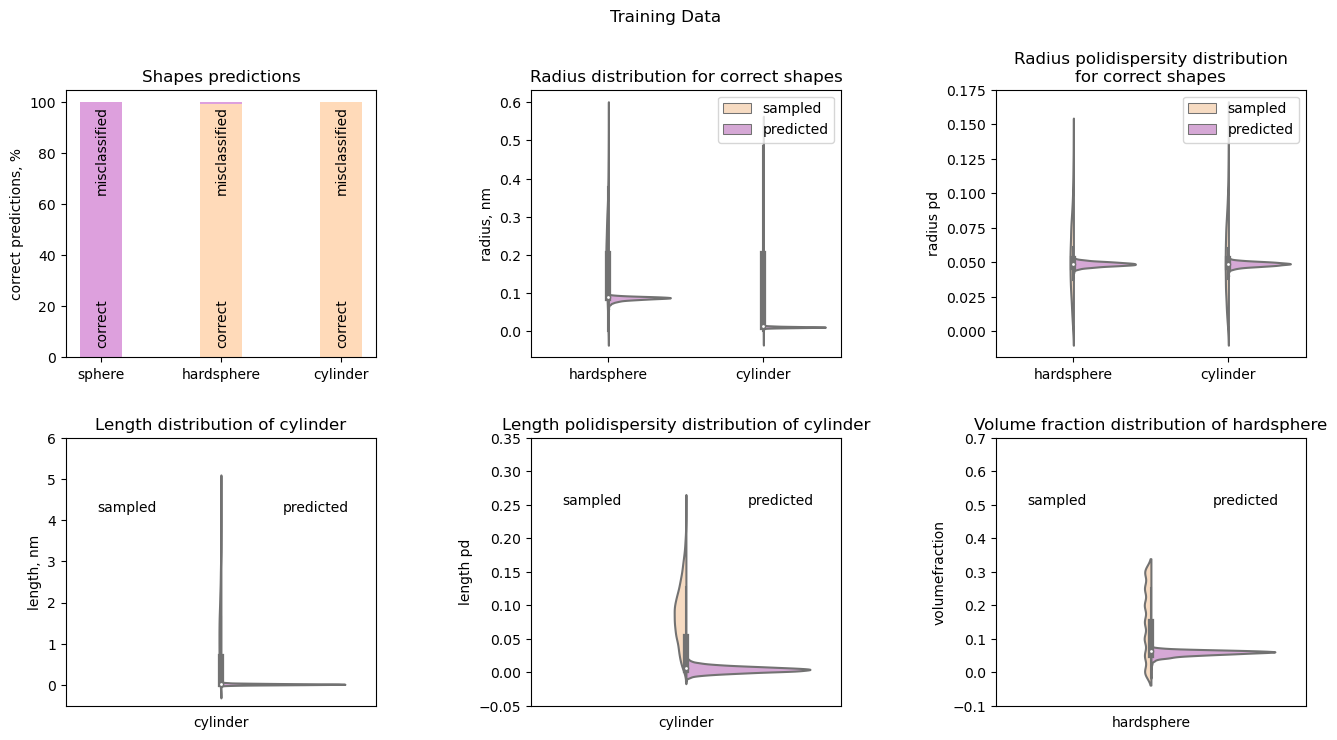

In [19]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 65.93%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: 0.0230 and cylinder: 0.0456
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: 0.0008 and cylinder: 0.0007
MSE for cylinder length for correctly identified instances: 2.2279
MSE for cylinder length polydispersity for correctly identified instances: 0.0089
MSE for cylinder length for correctly identified instances: 0.0191


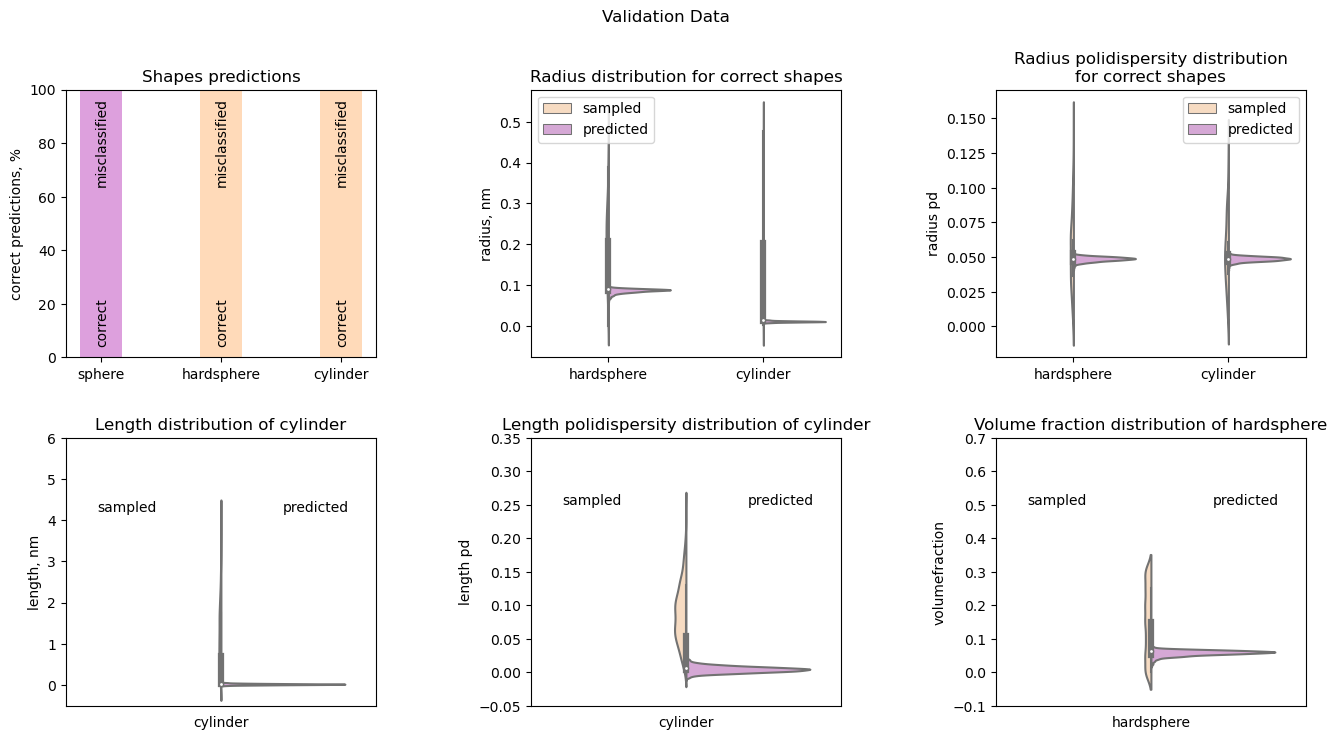

In [20]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 66.80%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: 0.0240 and cylinder: 0.0459
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: 0.0008 and cylinder: 0.0008
MSE for cylinder length for correctly identified instances: 2.3331
MSE for cylinder length polydispersity for correctly identified instances: 0.0085
MSE for cylinder length for correctly identified instances: 0.0194


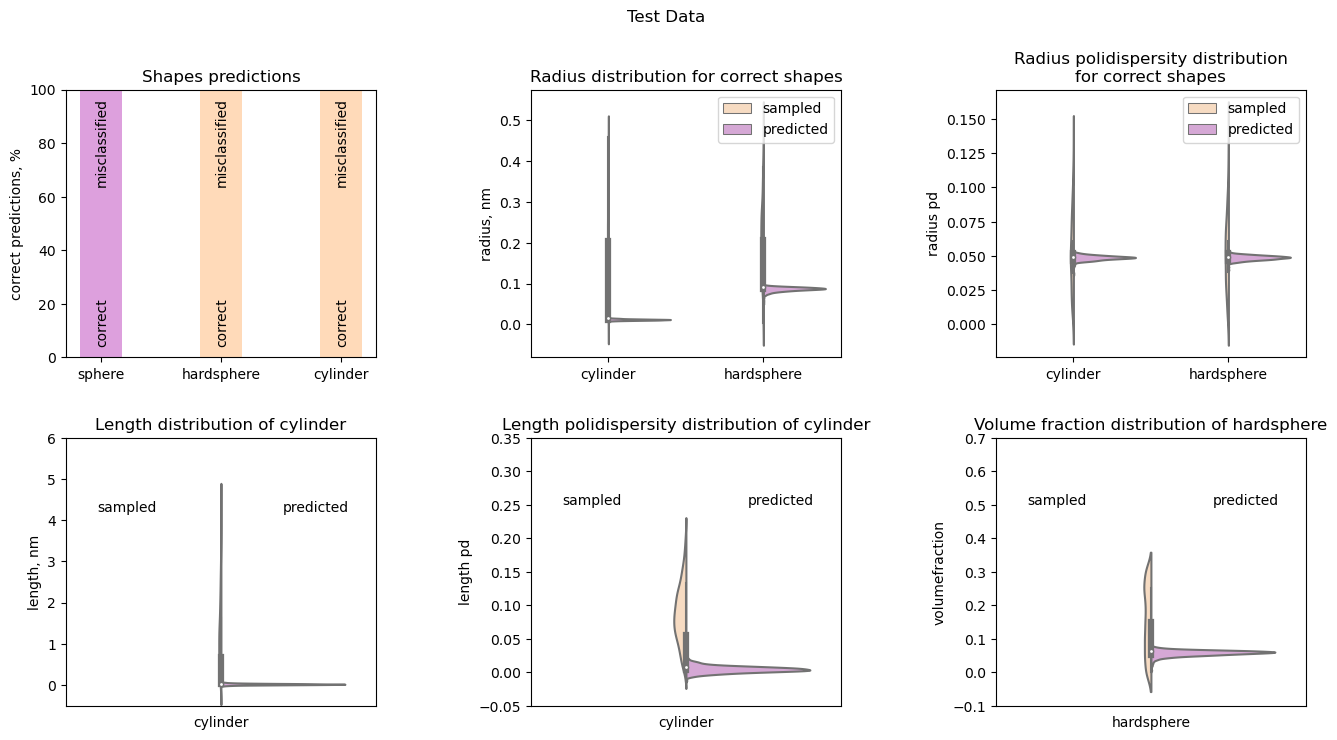

In [21]:
plot_outcomes_identified(df_test, 'Test')

In [22]:
false_shapes = df_test[df_test.true_shape != df_test.pred_shape]

FN_spheres = false_shapes[false_shapes.true_shape == 0]
FP_spheres = false_shapes[false_shapes.pred_shape == 0]
false_spheres = pd.concat([FN_spheres, FP_spheres])

FN_hardspheres = false_shapes[false_shapes.true_shape == 1]
FP_hardspheres = false_shapes[false_shapes.pred_shape == 1]
false_hardspheres = pd.concat([FN_hardspheres, FP_hardspheres])

FN_cylinders = false_shapes[false_shapes.true_shape == 2]
FP_cylinders = false_shapes[false_shapes.pred_shape == 2]
false_cylinders = pd.concat([FN_cylinders, FP_cylinders])

ValueError: There must be exactly two hue levels to use `split`.'

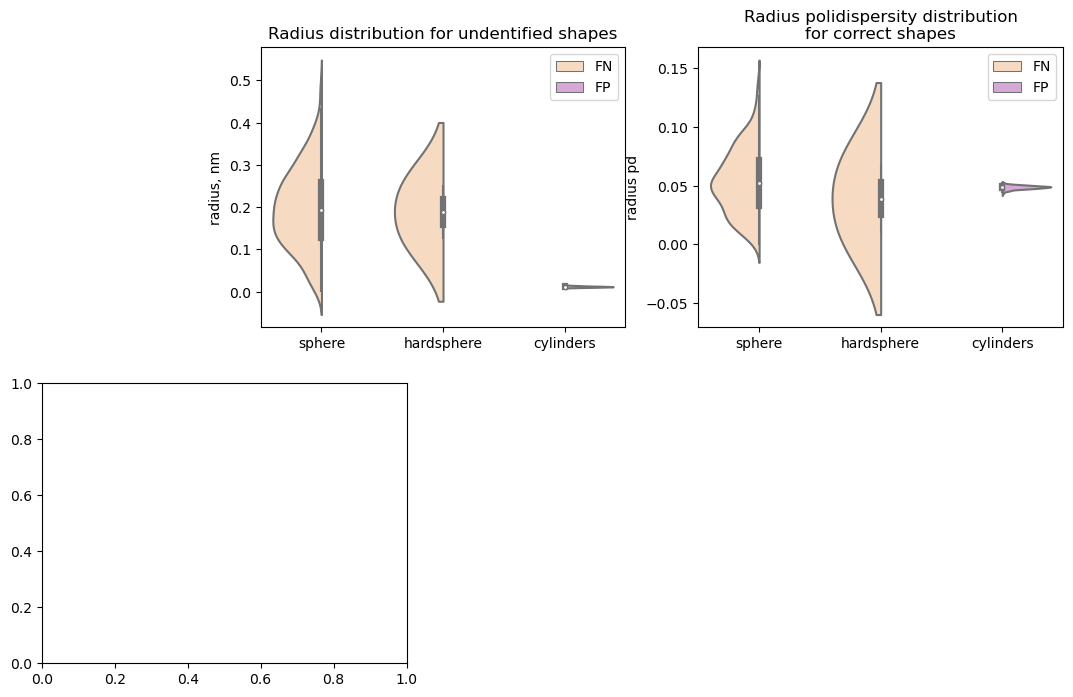

In [23]:
describe_false_shapes(false_spheres, false_hardspheres, false_cylinders)

ValueError: There must be exactly two hue levels to use `split`.'

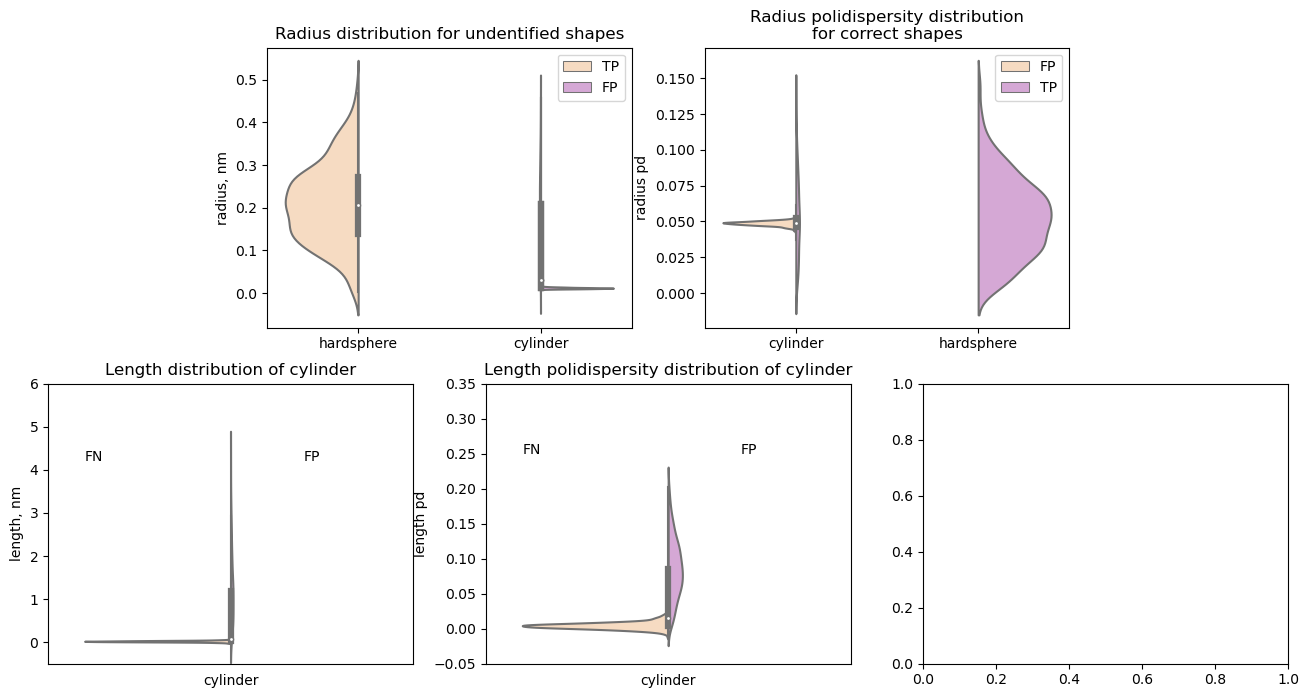

In [24]:
describe_positive_shapes(df_test)